# Notebook: Basic NLP Analyses v2

## Structure of notebook
#### Step 1: Imports, functions and classes
#### Step 2: Data preparation
#### Step 3: NLP basics
#### Step 4: Vectorization, analysis and basic plots
#### Step 5: Printing and plotting most influential words

## Step 1: Imports, functions and classes

In [1]:

####################################
## Requirements: spacy, en_core_web_sm, nltk stopwords
####################################

## General imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## Imports for NLP
import nltk, re, spacy, string
from spacy.lang.en.examples import sentences
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Imports for analyses
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

####################################
## Imports from analyses_tools (local) are included in this notebook in the following cell to increase accesibility
## If you want to import them instead use the following line:
# from analyses_tools import oh_encoder, data_preparation, text_cleaner, NLPAnalyzer
####################################


In [2]:

## Function for encoding

def oh_encoder(df, column):
    """Simple one-hot encoder that takes a dataframe and a column name and returns the dataframe with encoded column.
    """

    df = df.copy()
    all_categories = list(set(g for categories in df[column] for g in categories))
    one_hot_df = pd.DataFrame(0, index=df.index, columns=all_categories)
    for i, categories in enumerate(df[column]):
            one_hot_df.loc[i, categories] = 1
    df = df.drop(columns=[column]).join(one_hot_df)
        
    return df



## Function for data preparation

def data_preparation(df):
    """Take a dataframe, prepare it for use in NLP and analyses and return prepared dataframe.
    
    Args:
        df (Dataframe): Original dataframe to be prepared
        
    Returns:
        df (Dataframe): Prepared dataframe
        
    """

    df = df.copy()
    
    ###############################    
    ## Data Cleaning & Recoding
    ###############################
    
    ## drop columns not used in analyses
    df.drop(['sid', 'store_url', 'store_promo_url', 'published_meta', 'published_stsp', 'published_hltb',
           'published_igdb', 'image', 'current_price', 'discount', 
           'gfq_url', 'gfq_difficulty_comment', 'gfq_rating_comment', 'gfq_length_comment',
           'hltb_url', 'meta_url', 'igdb_url'], axis=1, inplace=True)
    
    ## publish date as timedelta
    df["published_store"] = pd.to_datetime(df["published_store"]) - pd.Timestamp(1997, 1, 1)
    df["published_store"] = df["published_store"].apply(lambda value: value.days)
     
    ## missing data 1: If language or voiceover is missing, set to "One_unknown"
    df.loc[df["languages"].isna(), "languages"] = "One_unknown"
    df.loc[df["voiceovers"].isna(), "voiceovers"] = "One_unknown"

    ## delete games without English as language:
    count_no_en = 0
    for x in df.index:
        if "english" not in df.loc[x,"languages"].lower():
            count_no_en += 1
            df = df.drop(labels=x, axis=0)
    print(f"Games without English language: {count_no_en}")
             
    ## use only number of languages and voiceovers
    df["languages"] = df["languages"].apply(lambda value: len(value.split(",")))
    df["voiceovers"] = df["voiceovers"].apply(lambda value: len(value.split(",")))
      
    ## missing data 2: drop columns with more than 75% missing data:
    for col in df.columns:
        if df[col].isna().sum() > df.shape[0]*0.75:
            df.drop(col, axis=1, inplace=True) 
    
    ## One-Hot-Encoding
    
    ## Genres
    ## split strings in genre and platform columns
    df['genres'] = df['genres'].apply(lambda x: x.split(','))
    df['platforms'] = df['platforms'].apply(lambda x: x.split(','))
    ## replace genres
    df['genres'] = df['genres'].apply(lambda genres: list(set(['Indie' if genre == 'Инди' else genre for genre in genres])))
    df['genres'] = df['genres'].apply(lambda genres: list(set(['Adventure' if genre == 'Приключенческие игры' else genre for genre in genres])))
    
    ## One-Hot Encoding
    df = oh_encoder(df, "genres")
    df = oh_encoder(df, "platforms")
    
    ## Rename columns including spaces
    df.rename(columns={'Game Development':'Game_Development',
                      'Free to Play':'Free_to_Play',
                      'Massively Multiplayer':'Massively_Multiplayer',
                      'Early Access':'Early_Access',
                      'Sexual Content':'Sexual_Content'}, inplace=True)

    return df


## Function for text cleaning

def text_cleaner(sentence):
    """Take a string, clean it for use in vectorization and return cleaned string.
    
    Args:
        sentence (string): Original string to be cleaned
        
    Returns:
        doc_str (string): Cleaned String
        
    """
    
    ## counter
    global call_count 
    call_count += 1
    if call_count%1000 == 0:
        print(call_count)
    if sentence is None:
        doc_str = ""
    else:
        ## tokenize and delete pronouns, stopwords and punctuation
        doc = nlp(sentence)
        clean_doc = [token.lemma_.lower() for token in doc if (token.pos_ !="PRON") and (token.lemma_ not in stopWords) and (token.lemma_ not in punctuations)]
        ## rejoin texts
        doc_str = " ".join(clean_doc)
        ## deleting points, tabs, spaces and line breaks
        doc_str = re.sub("[\s]+", " ", doc_str)
        ## deleting numbers
        doc_str = re.sub(r'\d+', '', doc_str) 
    return doc_str


## Class for analyses

class NLPAnalyzer():
    """A class used for the analyses including NLP.

        Attributes:

            df (Dataframe):
                The DataFrame to be used for analyses.
            target_var (string):
                The name of the target column.
            max_feature_list (list):
                A list of interger values to be used as maximum number of features for vectorization.
            test_size (float):
                The fraction of the Dataframe to be used as the test sample.
            tfidf (bool):
                A Boolean that is True if TF-IDF vectorization should be used instead of BOW/Count vectorization.
            var_dict (dictionary):
                A dictionary of potential targets with column names (keys) and column descriptions (values).
                These columns are excluded from analyses and only the target used in target_var is included as target.
            train_data (Dataframe):
                Data to be used as train features. Generated when runnning :meth: "analyze".
            test_data (Dataframe):
                Data to be used as test features. Generated when runnning :meth: "analyze".
            train_target (Dataframe):
                Data to be used as train target. Generated when runnning :meth: "analyze".
            test_target (Dataframe):
                Data to be used as test target. Generated when runnning :meth: "analyze".
            vectorizer (instance of vectorizer class from sklearn):
                Vectorizer used. Can be CountVectorizer or TfidfVectorizer. Generated when runnning :meth: analyze.
            model_sm (instance of statsmodels.api.OLS):
                OLS regression used for extraction of t-values. Generated when runnning :meth: analyze.
        
        Methods:
    
            analyze():
                Conduct analyses, print figures for Adjusted R-squared and T-values of non-NLP features. Return table of results.
  
            extract_words(max_features=50):
                Conduct OLS regression for max_features and return list of words showing significant effects and corresponding t-values.
                
            plot_words_multi(word_list_1, word_list_2, target_1, target_2, top_number=25):
                Plot words of two analyses extracted with :meth: extract_words.
                       
        """
    
    def __init__(self, df, target_var, target_name, max_feature_list=[0, 2000, 2500, 3000, 3500, 4000], test_size=0.25, tfidf=False, naming_suffix=""):
        """Construct all the necessary attributes for the NLPAnalyzer object.

        Args:
            df (Dataframe):
                The DataFrame to be used for analyses.
            target_var (string):
                The target column.
            target_name (string):
                The name of the target column (used for plotting).
            max_feature_list (list):
                A list of interger values to be used as maximum number of features for vectorization.
            test_size (float):
                The fraction of the Dataframe to be used as the test sample.
            tfidf (bool):
                A Boolean that is True if TF-IDF vectorization should be used instead of BOW/Count vectorization.
            naming_suffix (string):
                A string that is added to plots for simple comparison of different models for a specific target.
                
        """
        
        self.df = df.copy()
        self.target_var = target_var
        self.target_name = target_name
        self.test_size = test_size
        self.max_feature_list = max_feature_list
        self.tfidf = tfidf
        self.naming_suffix = naming_suffix
        
        print("*"*50, "\n", "Initialization - Target:", self.target_var, "\n", "*"*50)

        ## delete missings
        self.df = self.df.dropna(axis=0, how="any")

        ## Reset index
        self.df.reset_index()
        
        print("*"*50, "\n", "Data preparation done", "\n", "*"*50)

    
    def analyze(self):
        """Conduct analyses, print figures for Adjusted R-squared and T-values of non-NLP features. Return list of results.     
            
            Returns:
                results_df (Dataframe):
                    Dataframe of models used, maximum number of features and corresponding values of adjusted R-squared.
                    
        """
        
        # Train-test split
        self.train_data, self.test_data, self.train_target, self.test_target = train_test_split(
            self.df.drop([self.target_var], axis=1), self.df[self.target_var], test_size=self.test_size, random_state=42)
        
        # List for results
        results = []

        # Define the columns_to_scale list using a list comprehension
        columns_to_scale = [
        col for col in self.train_data.columns
        if self.train_data[col].nunique() > 2 and pd.api.types.is_numeric_dtype(self.train_data[col])
        ]

        # Print the columns to be scaled for debugging purposes
        print(f"Scaling the following columns for analyses: {columns_to_scale}")

        # Check if there are columns to scale
        if columns_to_scale:
            scaler = StandardScaler()
            self.train_data[columns_to_scale] = scaler.fit_transform(self.train_data[columns_to_scale])
            self.test_data[columns_to_scale] = scaler.transform(self.test_data[columns_to_scale])
        else:
            print("No columns to scale.")

        
        # Loop for different values of max_features
        for max_feat in self.max_feature_list:
            try:
                if max_feat > 0:

                    if self.tfidf:
                        self.vectorizer = TfidfVectorizer(
                            stop_words='english',
                            max_df=0.9,
                            min_df=10,
                            max_features=max_feat
                        )

                        print("*"*50, "\n", "Using TF-IDF Vectorizer", "\n", "*"*50)
        
                    else:
                        self.vectorizer = CountVectorizer(
                            stop_words='english',
                            max_df=0.9,
                            min_df=10,
                            max_features=max_feat
                        )
                        
                        print("*"*50, "\n", "Using BOW Vectorizer", "\n", "*"*50)
                    
                    # Fit and transformation
                    X_train_text = self.vectorizer.fit_transform(self.train_data['description_clean_nonum'])
                    X_test_text = self.vectorizer.transform(self.test_data['description_clean_nonum'])
                    
                    # Convert text features into dataframe
                    X_train_text_df = pd.DataFrame(X_train_text.toarray(), columns=self.vectorizer.get_feature_names_out(), index=self.train_data.index)
                    X_test_text_df = pd.DataFrame(X_test_text.toarray(), columns=self.vectorizer.get_feature_names_out(), index=self.test_data.index)
                else:
                    # When max_feat is 0, use only non-text features
                    X_train_text_df = pd.DataFrame()
                    X_test_text_df = pd.DataFrame()
               
                # Keep non-text features
                X_train_non_text = self.train_data.drop('description_clean_nonum', axis=1)
                X_test_non_text = self.test_data.drop('description_clean_nonum', axis=1)
                
                # Make sure all non-text features are numeric
                X_train_non_text = X_train_non_text.apply(pd.to_numeric, errors='coerce')
                X_test_non_text = X_test_non_text.apply(pd.to_numeric, errors='coerce')
                
                # Concatenate dataframes
                X_train = pd.concat([X_train_non_text, X_train_text_df], axis=1)
                X_test = pd.concat([X_test_non_text, X_test_text_df], axis=1)
                
                # Make sure all features are numeric
                X_train = X_train.apply(pd.to_numeric, errors='coerce')
                X_test = X_test.apply(pd.to_numeric, errors='coerce')
       
                print("*"*50, "\n", "NLP:", max_feat, "words - Vectorization done", "\n", "*"*50)
                
                
                # OLS with statsmodels
                self.model_sm = sm.OLS(self.train_target, sm.add_constant(X_train)).fit()
                adj_r2_sm = self.model_sm.rsquared_adj
                if max_feat == 0:
                    display(self.model_sm.summary())
                print("*"*50, "\n", "R-squared for Statsmodels OLS (train data):", self.model_sm.rsquared)
                print("*"*50, "\n", "Adjusted R-squared for Statsmodels OLS (train data):", adj_r2_sm)
                
                # Add constant to X_test for prediction
                X_test_const = sm.add_constant(X_test, has_constant='add')
                r2_sm_test = r2_score(self.test_target, self.model_sm.predict(X_test_const))
                adj_r2_sm_test = 1 - ( ( (1-r2_sm_test) * (len(self.test_target) - 1) ) / ( (len(self.test_target) - X_test_const.shape[1] - 1) ) )
                print("*"*50, "\n", "R-squared for Statsmodels OLS (test data):", r2_sm_test)    
                print("*"*50, "\n", "Adjusted R-squared for Statsmodels OLS (test data):", adj_r2_sm_test)                          
                results.append(('OLS', max_feat, adj_r2_sm_test))
              
                print("*"*50, "\n", "NLP:", max_feat, "words - OLS SM done", "\n", "*"*50)
        
                
                # OLS with sklearn
                model_lr = LinearRegression(fit_intercept=True).fit(X_train, self.train_target)
                r2_lr = r2_score(self.test_target, model_lr.predict(X_test))
                adj_r2_lr = 1 - (1-r2_lr)*(len(self.test_target)-1)/(len(self.test_target)-X_test.shape[1]-1)
                results.append(('LinearRegression', max_feat, adj_r2_lr))
                print(r2_lr, adj_r2_lr)
                print("*"*50, "\n", "NLP:", max_feat, "words - OLS SK done", "\n", "*"*50)
        
                
                # Lasso
                model_lasso = Lasso(fit_intercept=True, alpha=1e4).fit(X_train, self.train_target)
                r2_lasso = r2_score(self.test_target, model_lasso.predict(X_test))
                adj_r2_lasso = 1 - (1-r2_lasso)*(len(self.test_target)-1)/(len(self.test_target)-X_test.shape[1]-1)
                results.append(('Lasso', max_feat, adj_r2_lasso))
                print(r2_lasso, adj_r2_lasso)
                print("*"*50, "\n", "NLP:", max_feat, "words - Lasso done", "\n", "*"*50)
        
                
                # Ridge
                model_ridge = Ridge(fit_intercept=True, alpha=1e4).fit(X_train, self.train_target)
                r2_ridge = r2_score(self.test_target, model_ridge.predict(X_test))
                adj_r2_ridge = 1 - (1-r2_ridge)*(len(self.test_target)-1)/(len(self.test_target)-X_test.shape[1]-1)
                results.append(('Ridge', max_feat, adj_r2_ridge))
                print(r2_ridge, adj_r2_ridge)
                print("*"*50, "\n", "NLP:", max_feat, "words - Ridge done", "\n", "*"*50)

        
                # ElasticNet
                model_ela = ElasticNet(fit_intercept=True, alpha=1).fit(X_train, self.train_target)
                r2_ela = r2_score(self.test_target, model_ela.predict(X_test))
                adj_r2_ela = 1 - (1-r2_ela)*(len(self.test_target)-1)/(len(self.test_target)-X_test.shape[1]-1)
                results.append(('ElasticNet', max_feat, adj_r2_ela))
                print(r2_ela, adj_r2_ela)
                print("*"*50, "\n", "NLP:", max_feat, "words - ElasticNet done", "\n", "*"*50)

                
                # RandomForestRegressor
                model_rf = RandomForestRegressor(n_estimators=200, n_jobs=-1).fit(X_train, self.train_target)
                r2_rf = r2_score(self.test_target, model_rf.predict(X_test))
                adj_r2_rf = 1 - (1-r2_rf)*(len(self.test_target)-1)/(len(self.test_target)-X_test.shape[1]-1)
                results.append(('RandomForest', max_feat, adj_r2_rf))
                print(r2_rf, adj_r2_rf)
                print("*"*50, "\n", "NLP:", max_feat, "words - RF done", "\n", "*"*50)
                
            
            except ValueError as e:
                print(f"Error with max_features={max_feat}: {e}")
                continue

        # Convert results into dataframe
        self.results_df = pd.DataFrame(results, columns=['Model', 'Max_Features', 'Adjusted_R2'])
        self.results_df.loc[self.results_df["Adjusted_R2"]<0,"Adjusted_R2"] = 0.0
        
        # Plot adjusted R-squared for different max features
        plt.figure(figsize=(14, 7))
        for model in self.results_df['Model'].unique()[1:]:
            subset = self.results_df[self.results_df['Model'] == model]
            plt.plot(subset['Max_Features'], subset['Adjusted_R2'], label=model, alpha=0.5)
    
        plt.xlabel('Max Features')
        plt.ylabel('Adjusted R-squared')
        plt.title(f'Adjusted R-squared for Different Models (predicting {self.target_name})')
        plt.xticks(self.max_feature_list)
        plt.legend()
        plt.savefig(f'../../plots/fig_{self.target_var}_R2{self.naming_suffix}.png')
    
        # Plot t-values for non-text variables as horizontal bar plot
        # Sorting
        non_text_t_values = self.model_sm.tvalues[1:len(X_train_non_text.columns) + 1]
        non_text_feature_names = X_train_non_text.columns
        df_t_values = pd.DataFrame({
            'feature': non_text_feature_names,
            't_value': non_text_t_values
        })
        df_t_values_sorted = df_t_values.sort_values(by='t_value', ascending=False)
        non_text_t_values = df_t_values_sorted['t_value']
        non_text_feature_names = df_t_values_sorted['feature']

        plt.figure(figsize=(14, 7))
        plt.barh(non_text_feature_names, non_text_t_values, color="cornflowerblue")
        plt.xlabel('T-values')
        plt.ylabel('Non-text Features')
        plt.title(f'T-values for Non-text Variables (predicting {self.target_name})')

        max_y=len(non_text_feature_names)
        min_x= min(non_text_t_values)-0.5
        max_x= max(non_text_t_values)+0.5
        l1=plt.axvline(1.96, color="green", alpha=0.75)
        l2=plt.axvline(-1.96, color="green", alpha=0.75)
        plt.axvline(0, color="cornflowerblue", alpha=0.5)
        f1=plt.gca().fill_between(x=[-1.96, 1.96], y1=-1, y2=max_y, color="red", alpha=0.075)
        f2=plt.gca().fill_between(x=[min_x,-1.96], y1=-1, y2=max_y, color="green", label="Significant with p<0.05", alpha=0.075)
        f3=plt.gca().fill_between(x=[1.96, max_x], y1=-1, y2=max_y, color="green", alpha=0.075)
        
        legend = plt.gca().get_legend()
        if legend:
            legend.remove()        
        ax2=plt.gca().twinx()
        ax2.legend(handles=[f2], loc=1)

        plt.tight_layout()
        plt.savefig(f'../../plots/fig_{self.target_var}_Tvalues{self.naming_suffix}.png')
    
        return self.results_df

    
    def extract_words(self, max_features=50):
        """Conduct OLS regression for max_features and return list of significant words and corresponding t-values.
                
            Args:      
                max_features (int):
                    maximum number of features to be used for extraction of words showing significant effects.
                        
            Returns:
                significant_words (list):
                    List of words showing significant effects and corresponding t-values.

        """
        

        max_feat = max_features
        
        # OLS for t-value extraction with specific number of words
        try:
            if max_features > 0:

                if self.tfidf:
                    self.vectorizer = TfidfVectorizer(
                        stop_words='english',
                        max_df=0.9,
                        min_df=5,
                        max_features=max_feat
                    )

                    print("*"*50, "\n", "Using TF-IDF Vectorizer", "\n", "*"*50)
        
                else:
                    self.vectorizer = CountVectorizer(
                        stop_words='english',
                        max_df=0.9,
                        min_df=5,
                        max_features=max_feat
                    )
                        
                    print("*"*50, "\n", "Using BOW Vectorizer", "\n", "*"*50)
                    
                # Fit and transformation
                X_train_text = self.vectorizer.fit_transform(self.train_data['description_clean_nonum'])
                X_test_text = self.vectorizer.transform(self.test_data['description_clean_nonum'])
                    
                # Convert text features into dataframe
                X_train_text_df = pd.DataFrame(X_train_text.toarray(), columns=self.vectorizer.get_feature_names_out(), index=self.train_data.index)
                X_test_text_df = pd.DataFrame(X_test_text.toarray(), columns=self.vectorizer.get_feature_names_out(), index=self.test_data.index)
            
            else:
                # When max_feat is 0, word extraction is not conducted
                print("There are no influential words if maximum number of text features is zero.")
                return self
               
            # Keep non-text features
            X_train_non_text = self.train_data.drop('description_clean_nonum', axis=1)
            X_test_non_text = self.test_data.drop('description_clean_nonum', axis=1)
                
            # Make sure all non-text features are numeric
            X_train_non_text = X_train_non_text.apply(pd.to_numeric, errors='coerce')
            X_test_non_text = X_test_non_text.apply(pd.to_numeric, errors='coerce')
                
            # Concatenate dataframes
            X_train = pd.concat([X_train_non_text, X_train_text_df], axis=1)
            X_test = pd.concat([X_test_non_text, X_test_text_df], axis=1)
                
            # Make sure all features are numeric
            X_train = X_train.apply(pd.to_numeric, errors='coerce')
            X_test = X_test.apply(pd.to_numeric, errors='coerce')
      
            print("*"*50, "\n", "NLP:", max_feat, "words - Vectorization done", "\n", "*"*50)
              
            # OLS with statsmodels
            self.model_sm = sm.OLS(self.train_target, sm.add_constant(X_train)).fit()
                         
        except ValueError as e:
            print(f"Error with max_features={max_feat}: {e}")
      
        # Extract significant words
        significant_words = []
        text_feature_names = self.vectorizer.get_feature_names_out()
        
        for i, feature_name in enumerate(text_feature_names):
            t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]
            
            if abs(t_value) > 1.96:
                significant_words.append((feature_name, t_value))
        
        return significant_words


    def plot_words(self, number_words=50, max_words=25):
        """Plot words with significant influence on target variable in OLS regression.

        Args:
            number_words (int):
                Number of words to be used in OLS regression for extraction of words.
            max_words (int):
                Maximum number of words to be plotted.

        Returns:
            top (list):
                List of top words with highest t-values. Length is based on max_words.
                
        """

        # Sort word lists based on t-values in descending order
        sorted_words = sorted(self.extract_words(number_words), key=lambda x: x[1], reverse=True)
        
        # Extract top words
        top = sorted_words[:max_words]

        # Extract words and t-values
        words = [entry[0] for entry in top]
        t_values = [entry[1] for entry in top]
         
        # Plot
        plt.figure(figsize=(12, 8))
               
        # Make barh plot
        w1=plt.barh(words, t_values, color="cornflowerblue", label=self.target_name, alpha=0.5)
        plt.xlabel('T-values')
        plt.ylabel('Words')
        plt.title(f'T-values of most influential words in models for {self.target_name}')
        
        max_y=len(words)
        min_x= min(t_values)-0.5
        max_x= max(t_values)+0.5
        l1=plt.axvline(1.96, color="green", alpha=0.75)
        l2=plt.axvline(-1.96, color="green", alpha=0.75)
        plt.axvline(0, color="cornflowerblue", alpha=0.5)
        f1=plt.gca().fill_between(x=[-1.96, 1.96], y1=-1, y2=max_y, color="red", alpha=0.075)
        f2=plt.gca().fill_between(x=[min_x,-1.96], y1=-1, y2=max_y, color="green", label="Significant with p<0.05", alpha=0.075)
        f3=plt.gca().fill_between(x=[1.96, max_x], y1=-1, y2=max_y, color="green", alpha=0.075)
        
        legend = plt.gca().get_legend()
        if legend:
            legend.remove()
        ax2=plt.gca().twinx()
        ax2.legend(handles=[f2], loc=1)
        
        plt.tight_layout()
        plt.savefig(f'../../plots/fig_word_t-values_{self.target_var}{self.naming_suffix}.png')

        return top


    def plot_words_multi(self, word_list_1, word_list_2, target_1, target_2, max_words=25):
        """Plot words of two analyses extracted with :meth: extract_words.

        Args:
            words_list_1 (list):
                List of words and corresponding t-values extracted with :meth: extract_words. 
            words_list_1 (list):
                List of words and corresponding t-values extracted with :meth: extract_words. 
            target_1 (string):
                Name of dependent variable predicted with word_list_1. 
            target_2 (string):
                Name of dependent variable predicted with word_list_2. 
            max_words (int):
                Maximum number of words to be extracted and plotted.

            Returns:
                top_1 (list):
                    List of top words with highest t-values from word_list_1. Length is based on :attr: max_words.
                top_2 (list):
                    List of top words with highest t-values from word_list_1. Length is based on :attr: max_words.
                
        """

        # Sort word lists based on t-values in descending order
        sorted_words_1 = sorted(word_list_1, key=lambda x: x[1], reverse=True)
        sorted_words_2 = sorted(word_list_2, key=lambda x: x[1], reverse=True)
        
        # Extract top words
        top_1 = sorted_words_1[:max_words]
        top_2 = sorted_words_2[:max_words]
        
        # Plot
        plt.figure(figsize=(12, 8))
        
        # Extract words and t-values
        words_1 = [entry[0] for entry in top_1]
        t_values_1 = [entry[1] for entry in top_1]
        words_2 = [entry[0] for entry in top_2]
        t_values_2 = [entry[1] for entry in top_2]
        
        # Make barh plot
        w1=plt.barh(words_1, t_values_1, color='orange', label=target_1, alpha=0.5)
        w2=plt.barh(words_2, t_values_2, color="cornflowerblue", label=target_2, alpha=0.5)
        plt.xlabel('T-values')
        plt.ylabel('Words')
        plt.title(f'T-values of most influential words in models for {target_1} and {target_2}')

        unique_values = list(set(words_1) | set(words_2))
        max_y=len(unique_values)
        min_x= min(min(t_values_1), max(t_values_1))-0.5
        max_x= max(max(t_values_1), max(t_values_1))+0.5
        l1=plt.axvline(1.96, color="green", alpha=0.75)
        l2=plt.axvline(-1.96, color="green", alpha=0.75)
        plt.axvline(0, color="cornflowerblue", alpha=0.5)
        f1=plt.gca().fill_between(x=[-1.96, 1.96], y1=-1, y2=max_y, color="red", alpha=0.075)
        f2=plt.gca().fill_between(x=[min_x,-1.96], y1=-1, y2=max_y, color="green", label="Significant with p<0.05", alpha=0.075)
        f3=plt.gca().fill_between(x=[1.96, max_x], y1=-1, y2=max_y, color="green", alpha=0.075)
        plt.gca().legend(handles=[w1, w2], loc=2, title="Models")
        ax2=plt.gca().twinx()
        ax2.legend(handles=[f2], loc=1)
        
        plt.tight_layout()
        plt.savefig(f'../../plots/fig_word_t-values_{target_1.replace(" ", "")}_{target_2.replace(" ", "")}{self.naming_suffix}.png')

        return top_1, top_2




## Step 2: Data preparation

In [3]:
## Read data
df = pd.read_json("../../data/steamdb.json")

## Prepare data
df = data_preparation(df)


Games without English language: 1931


## Step 3: NLP basics

In [4]:

## load language model
nlp = spacy.load("en_core_web_sm")

#########################################
## Users might need to manually download stopwords:
# nltk.download('stopwords')
#########################################

## Clean "description"
stopWords = stopwords.words("english")
punctuations = string.punctuation

## Applying text_cleaner to description
print("*"*50 + "\nStarting text cleaner\n" + "*"*50) 
## Adding a global counter to print in text_cleaner function since it takes a long time
call_count = 0
## Using text_cleaner
df["description_clean_nonum"] = df["description"].apply(text_cleaner)



**************************************************
Starting text cleaner
**************************************************
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000


In [5]:
#########################################
## optional: save as pickle for fast reload
# df.to_pickle("../../data/df_with_lemmas_compressed.pkl", compression='bz2')
#########################################

## Step 4: Vectorization, analysis and basic plots

In [6]:
#########################################
## optional: if saved as pickle, load it here:
# df = pd.read_pickle("../../data/df_with_lemmas_compressed.pkl", compression='bz2')
#########################################

************************************************** 
 Initialization - Target: stsp_owners 
 **************************************************
************************************************** 
 Data preparation done 
 **************************************************
Scaling the following columns for analyses: ['published_store', 'full_price', 'languages', 'voiceovers']
************************************************** 
 NLP: 0 words - Vectorization done 
 **************************************************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            stsp_owners   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     53.09
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          6.74e-247
Time:                        04:29:35   Log-Likelihood:            -3.3672e+05
No. Observations:               22572   AIC:                         6.735e+05
Df Residuals:                   22547   BIC:                         6.737e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.133e+04   4.21e+05      0.027      0.979   -8.14e+05    8.37e+05
published_store       -1.262e+05   5152.892    -24.483      0.000   -1.36e+05   -1.16e+05
full_price             5.538e+04   4889.805     11.325      0.000    4.58e+04     6.5e+04
languages              8.909e+04   5881.568     15.148      0.000    7.76e+04    1.01e+05
voiceovers            -1.489e+04   5852.944     -2.545      0.011   -2.64e+04   -3422.288
Strategy              -1.162e+04   1.27e+04     -0.913      0.362   -3.66e+04    1.33e+04
Simulation             1.381e+04   1.29e+04      1.071      0.284   -1.15e+04    3.91e+04
Casual                  -2.1e+04   1.04e+04     -2.020      0.043   -4.14e+04    -625.247
Nudity                -2.902e+04   8.79e+04     -0.330      0.741   -2.01e+05    1.43e+05
Sports                -1.457e+04   2.34e+04     -0.623      0.533   -6.04e+04    3.13e+04
Violent               -1.917e+04   4.66e+04     -0.412      0.681    -1.1e+05    7.21e+04
Adventure               312.6024   1.05e+04      0.030      0.976   -2.02e+04    2.08e+04
RPG                    2536.0856   1.37e+04      0.185      0.854   -2.44e+04    2.95e+04
Sexual_Content         1140.7100   8.93e+04      0.013      0.990   -1.74e+05    1.76e+05
Action                 2.002e+04   1.03e+04      1.943      0.052    -175.097    4.02e+04
Early_Access           3692.9254   1.57e+04      0.236      0.814    -2.7e+04    3.44e+04
Game_Development       3.644e+04   2.58e+05      0.141      0.888   -4.69e+05    5.42e+05
Racing                -3.423e+04   2.61e+04     -1.309      0.190   -8.55e+04     1.7e+04
Free_to_Play          -1.707e+04   2.04e+04     -0.838      0.402    -5.7e+04    2.29e+04
Gore                  -2.457e+04   6.09e+04     -0.403      0.687   -1.44e+05    9.48e+04
Movie                  2.272e-11   2.83e-10      0.080      0.936   -5.32e-10    5.77e-10
Massively_Multiplayer -2.237e+04   3.09e+04     -0.723      0.470    -8.3e+04    3.83e+04
Indie                 -2.367e+04   1.15e+04     -2.063      0.039   -4.62e+04   -1179.519
LNX                    4.872e+04   1.59e+04      3.071      0.002    1.76e+04    7.98e+04
MAC                     1.73e+04   1.37e+04      1.261      0.207   -9596.598    4.42e+04
WIN                    9.103e+04   4.21e+05      0.216      0.829   -7.35e+05    9.17e+05
==============================================================================
Omnibus:                    74497.158   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      25108254236.817
Skew:                          56.976   Prob(JB):                         0.00
Kurtosis:                    5168.629   Cond. No.                     1.22e+16
==============================================================================

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.05349230951199968
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.052484805871971574
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.0697765431937265
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.06655090837417954
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.0697765431937265 0.06667538484992641
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
0.06712329908270631 0.06401329541249268
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.061732235110549594 0.0586042588307474

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           store_uscore   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     23.63
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          4.39e-107
Time:                        04:33:44   Log-Likelihood:                -93726.
No. Observations:               21289   AIC:                         1.875e+05
Df Residuals:                   21263   BIC:                         1.877e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    66.4746      8.852      7.509      0.000      49.123      83.826
published_store          -0.6943      0.144     -4.821      0.000      -0.977      -0.412
full_price                1.8189      0.137     13.313      0.000       1.551       2.087
languages                 2.3424      0.161     14.559      0.000       2.027       2.658
voiceovers               -0.3133      0.160     -1.959      0.050      -0.627       0.000
Strategy                 -0.3558      0.354     -1.005      0.315      -1.050       0.338
Simulation               -0.6687      0.360     -1.857      0.063      -1.375       0.037
Casual                   -1.3295      0.292     -4.556      0.000      -1.902      -0.757
Nudity                    6.1961      2.486      2.493      0.013       1.324      11.068
Sports                   -0.8448      0.663     -1.274      0.203      -2.145       0.455
Violent                  -2.5806      1.302     -1.982      0.047      -5.132      -0.029
Adventure                -0.2135      0.293     -0.730      0.466      -0.787       0.360
RPG                       0.1223      0.384      0.318      0.750      -0.631       0.875
Sexual_Content           -4.4974      2.455     -1.832      0.067      -9.310       0.315
Action                   -0.0046      0.288     -0.016      0.987      -0.570       0.561
Early_Access              0.8205      0.439      1.870      0.062      -0.040       1.681
Game_Development         -3.5460      8.079     -0.439      0.661     -19.381      12.289
Racing                   -0.0578      0.733     -0.079      0.937      -1.494       1.379
Free_to_Play             -0.3384      0.579     -0.585      0.559      -1.473       0.796
Gore                     -1.3085      1.655     -0.791      0.429      -4.552       1.935
Movie                    17.6557     19.798      0.892      0.373     -21.151      56.462
Massively_Multiplayer    -0.2964      0.860     -0.344      0.731      -1.983       1.390
Indie                     0.1727      0.321      0.539      0.590      -0.456       0.801
LNX                       0.3951      0.438      0.901      0.367      -0.464       1.255
MAC                      -0.0753      0.379     -0.199      0.842      -0.818       0.667
WIN                       4.4184      8.850      0.499      0.618     -12.928      21.765
==============================================================================
Omnibus:                     1755.618   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2223.467
Skew:                          -0.787   Prob(JB):                         0.00
Kurtosis:                       3.175   Cond. No.                         267.
==============================================================================

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.02702841324435512
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.025884440631417704
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.02691442680236722
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.023335894284242986
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.026914426802366886 0.023474016771262263
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-0.0008753112082124925 -0.004413973742536603
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.02463709512451895 0.0211886

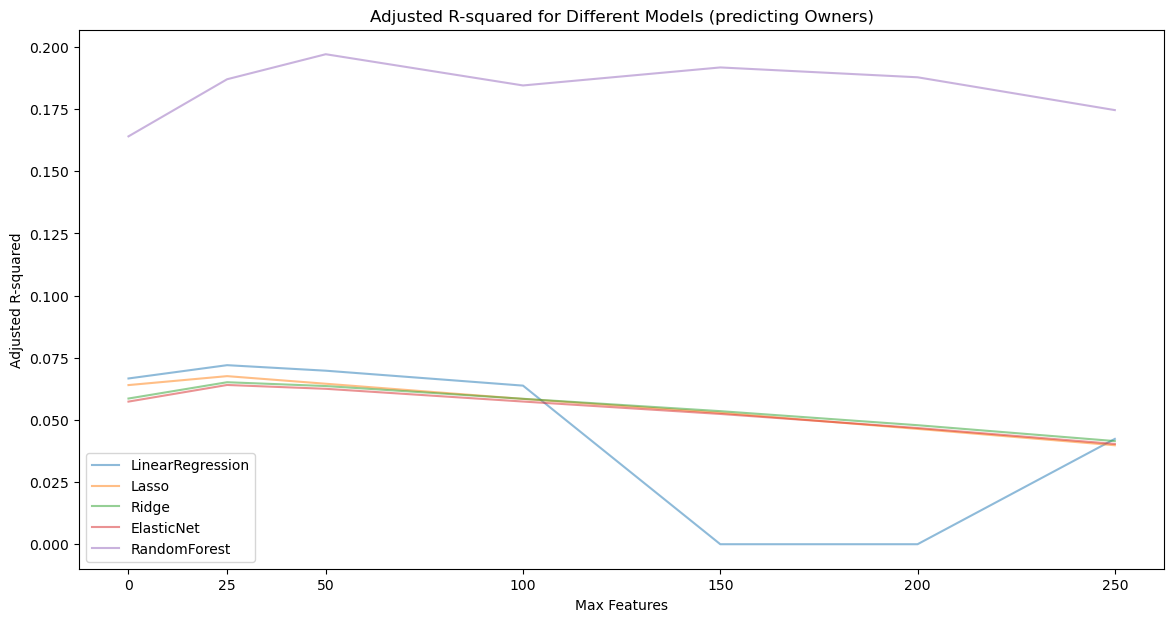

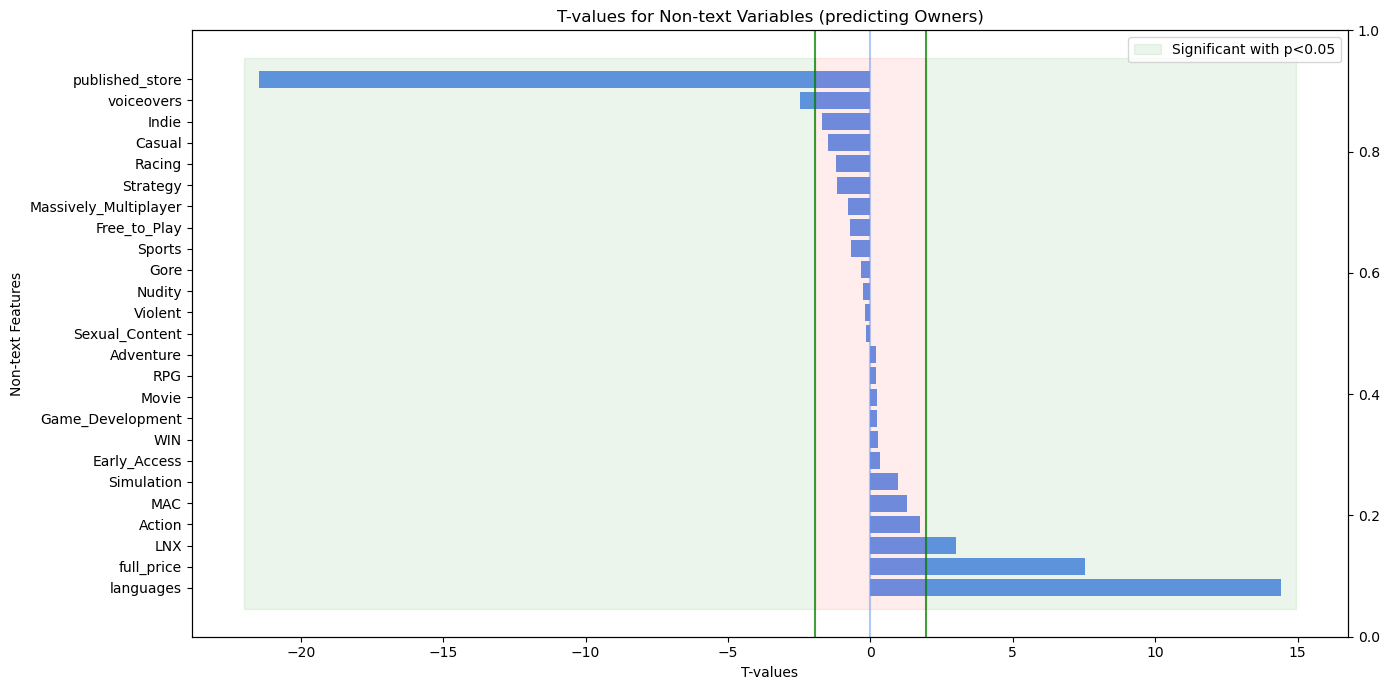

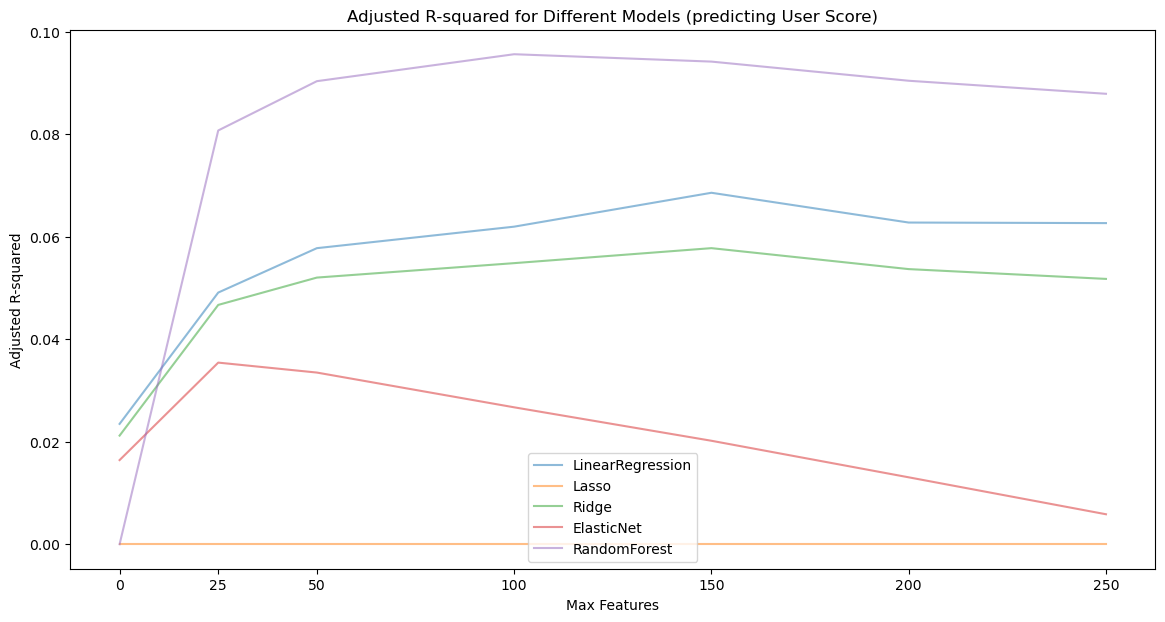

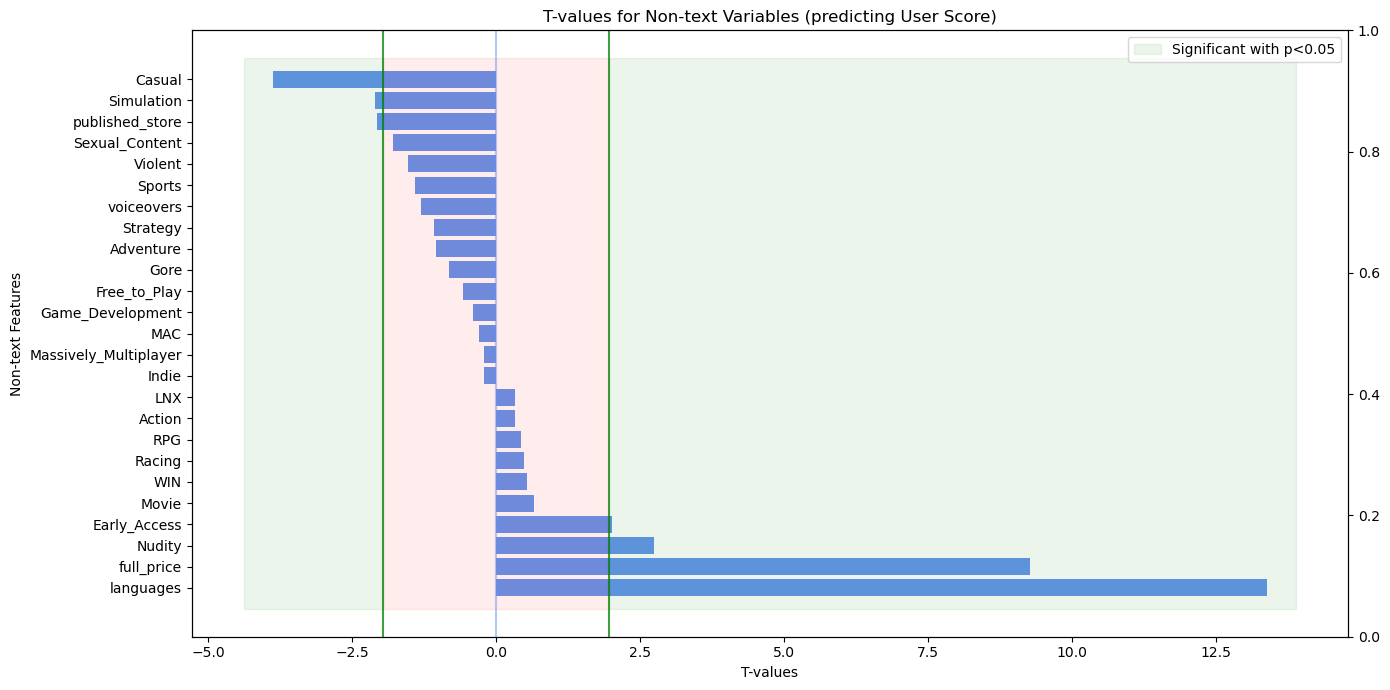

In [7]:

## Use NLPAnalyzer class to conduct basic analyses and save basic plots of results
        
NLP_owners = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", "store_uscore", 
                                  "igdb_popularity"], axis=1), 
                         "stsp_owners", "Owners",
                         [0, 25, 50, 100, 150, 200, 250]) 
results_owners = NLP_owners.analyze()

NLP_uscore = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description",
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "store_uscore", "User Score",
                         [0, 25, 50, 100, 150, 200, 250])
results_uscore = NLP_uscore.analyze()


************************************************** 
 Initialization - Target: stsp_owners 
 **************************************************
************************************************** 
 Data preparation done 
 **************************************************
Scaling the following columns for analyses: ['published_store', 'full_price', 'languages', 'voiceovers', 'hltb_single']
************************************************** 
 NLP: 0 words - Vectorization done 
 **************************************************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            stsp_owners   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     39.78
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          5.07e-182
Time:                        04:37:08   Log-Likelihood:            -1.2053e+05
No. Observations:                8061   AIC:                         2.411e+05
Df Residuals:                    8035   BIC:                         2.413e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9.233e+04   7.56e+05     -0.122      0.903   -1.57e+06    1.39e+06
published_store       -1.664e+05   9348.518    -17.799      0.000   -1.85e+05   -1.48e+05
full_price             1.238e+05   9148.390     13.528      0.000    1.06e+05    1.42e+05
languages              1.205e+05   9936.401     12.130      0.000    1.01e+05     1.4e+05
voiceovers               36.2242   9719.164      0.004      0.997    -1.9e+04    1.91e+04
hltb_single            4.754e+04   8920.043      5.329      0.000    3.01e+04     6.5e+04
Strategy               -734.8480   2.22e+04     -0.033      0.974   -4.42e+04    4.27e+04
Simulation            -1.572e+04   2.27e+04     -0.693      0.488   -6.02e+04    2.87e+04
Casual                -2.715e+04   1.89e+04     -1.436      0.151   -6.42e+04    9907.754
Nudity                -5.445e+04   1.54e+05     -0.355      0.723   -3.55e+05    2.46e+05
Sports                -1.627e+04   4.42e+04     -0.368      0.713   -1.03e+05    7.04e+04
Violent                4.813e+04   8.96e+04      0.537      0.591   -1.27e+05    2.24e+05
Adventure             -2.537e+04   1.82e+04     -1.393      0.164   -6.11e+04    1.03e+04
RPG                   -1.162e+04   2.34e+04     -0.496      0.620   -5.76e+04    3.43e+04
Sexual_Content          2.33e+04   1.55e+05      0.150      0.881   -2.81e+05    3.28e+05
Action                 4.981e+04   1.81e+04      2.755      0.006    1.44e+04    8.53e+04
Early_Access          -3326.8243   2.94e+04     -0.113      0.910    -6.1e+04    5.44e+04
Game_Development      -1.081e+05   7.56e+05     -0.143      0.886   -1.59e+06    1.37e+06
Racing                -7.296e+04    4.6e+04     -1.587      0.112   -1.63e+05    1.71e+04
Free_to_Play          -1.878e+04   3.79e+04     -0.495      0.621   -9.32e+04    5.56e+04
Gore                   9.168e+04    1.1e+05      0.835      0.404   -1.24e+05    3.07e+05
Movie                  -1.24e-11   9.83e-11     -0.126      0.900   -2.05e-10     1.8e-10
Massively_Multiplayer  -1.44e+04    5.5e+04     -0.262      0.794   -1.22e+05    9.35e+04
Indie                 -2.494e+04   1.97e+04     -1.268      0.205   -6.35e+04    1.36e+04
LNX                    3.166e+04   2.67e+04      1.187      0.235   -2.06e+04    8.39e+04
MAC                    5.785e+04   2.36e+04      2.456      0.014    1.17e+04    1.04e+05
WIN                     2.87e+05   7.56e+05      0.380      0.704   -1.19e+06    1.77e+06
==============================================================================
Omnibus:                    17138.077   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        129523955.659
Skew:                          18.339   Prob(JB):                         0.00
Kurtosis:                     622.908   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.11014220583569401
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.10737351325895372
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.14487577654432726
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.13619267987892558
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.14487577654432726 0.13651741947295604
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
0.1346463631929048 0.12618801937448954
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.0919694374296186 0.08309395072780279


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           store_uscore   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     9.282
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           7.09e-35
Time:                        04:38:24   Log-Likelihood:                -33557.
No. Observations:                7937   AIC:                         6.717e+04
Df Residuals:                    7911   BIC:                         6.735e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    87.1527     16.637      5.239      0.000      54.540     119.765
published_store           0.7451      0.208      3.579      0.000       0.337       1.153
full_price                1.3398      0.204      6.557      0.000       0.939       1.740
languages                 1.2609      0.218      5.773      0.000       0.833       1.689
voiceovers                0.2232      0.213      1.046      0.295      -0.195       0.641
hltb_single               0.7760      0.199      3.897      0.000       0.386       1.166
Strategy                 -0.7688      0.490     -1.570      0.116      -1.729       0.191
Simulation               -1.4607      0.510     -2.862      0.004      -2.461      -0.460
Casual                   -0.9511      0.418     -2.273      0.023      -1.771      -0.131
Nudity                    0.9696      3.218      0.301      0.763      -5.338       7.277
Sports                   -0.4699      0.961     -0.489      0.625      -2.354       1.414
Violent                  -3.0566      2.021     -1.513      0.130      -7.017       0.904
Adventure                 0.5652      0.405      1.397      0.163      -0.228       1.359
RPG                      -0.7261      0.518     -1.400      0.161      -1.742       0.290
Sexual_Content           -0.8039      3.248     -0.248      0.804      -7.170       5.562
Action                   -0.0139      0.402     -0.035      0.972      -0.802       0.774
Early_Access              1.7902      0.663      2.699      0.007       0.490       3.090
Game_Development         -2.8225     16.634     -0.170      0.865     -35.430      29.785
Racing                    0.0105      1.006      0.010      0.992      -1.961       1.982
Free_to_Play             -0.1739      0.844     -0.206      0.837      -1.829       1.481
Gore                      1.6744      2.526      0.663      0.507      -3.277       6.626
Movie                 -3.257e-14   1.89e-13     -0.172      0.863   -4.04e-13    3.39e-13
Massively_Multiplayer    -1.6967      1.226     -1.384      0.166      -4.099       0.706
Indie                    -0.0553      0.437     -0.126      0.899      -0.912       0.802
LNX                       0.4036      0.591      0.683      0.495      -0.755       1.562
MAC                       0.4990      0.525      0.950      0.342      -0.531       1.529
WIN                      -9.5264     16.635     -0.573      0.567     -42.135      23.082
==============================================================================
Omnibus:                     1349.389   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2204.053
Skew:                          -1.153   Prob(JB):                         0.00
Kurtosis:                       4.159   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.028496552695735256
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.025426449525136507
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.025003172359431947
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.014947819285980768
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.025003172359431947 0.015323936957120199
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-0.00015509318050477283 -0.010084086087222222
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.019935356528270054 0.010

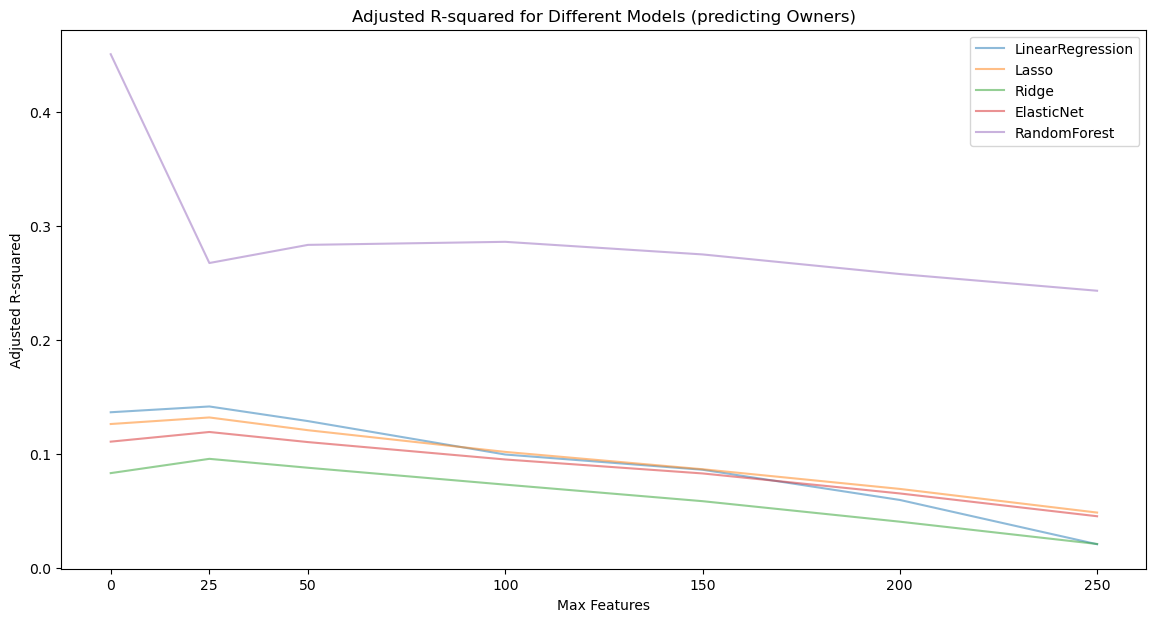

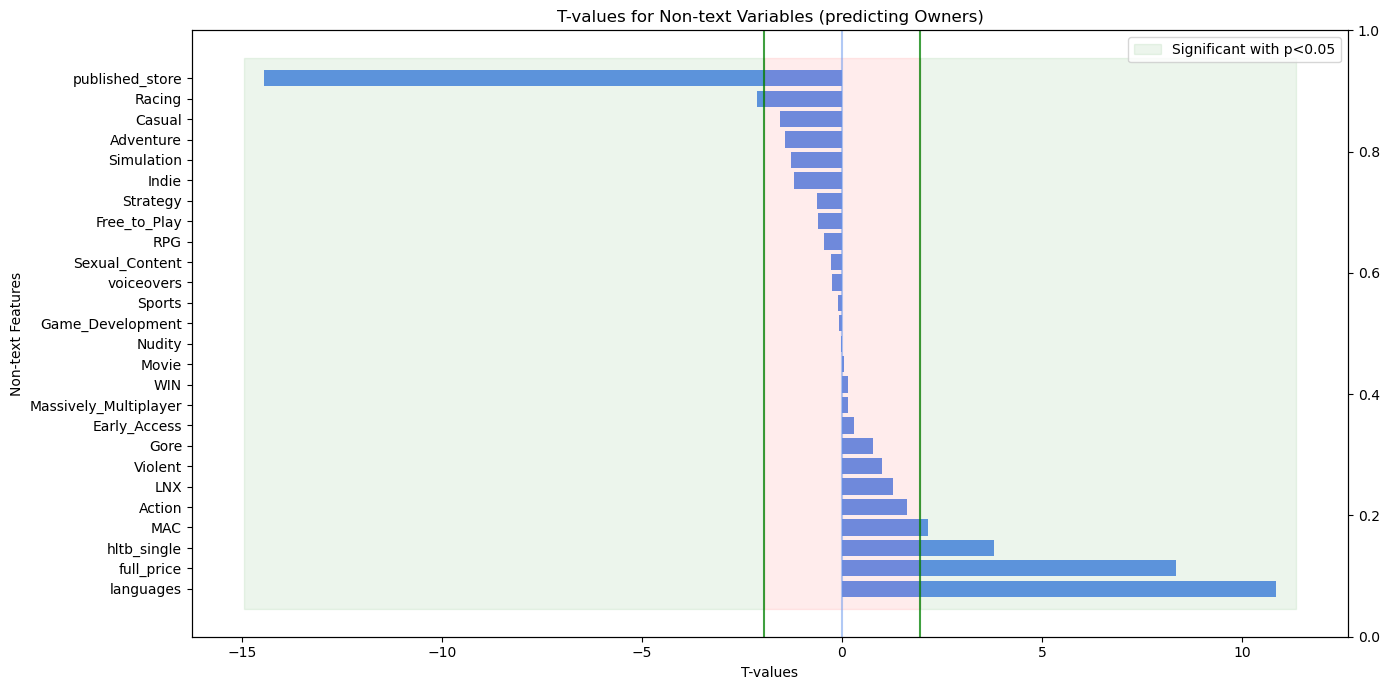

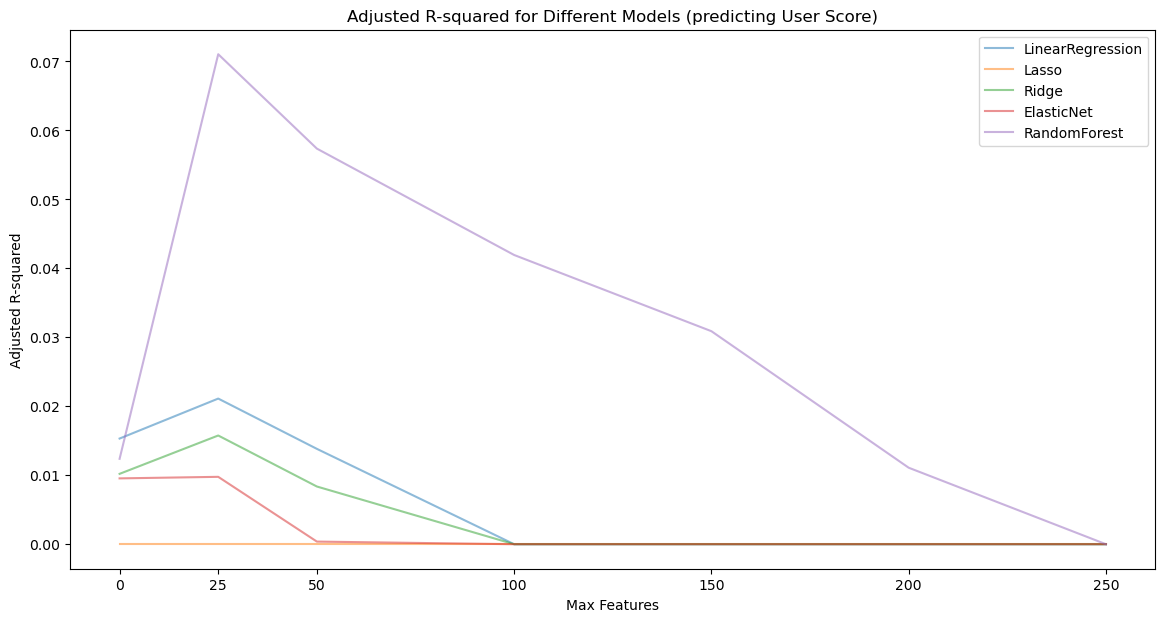

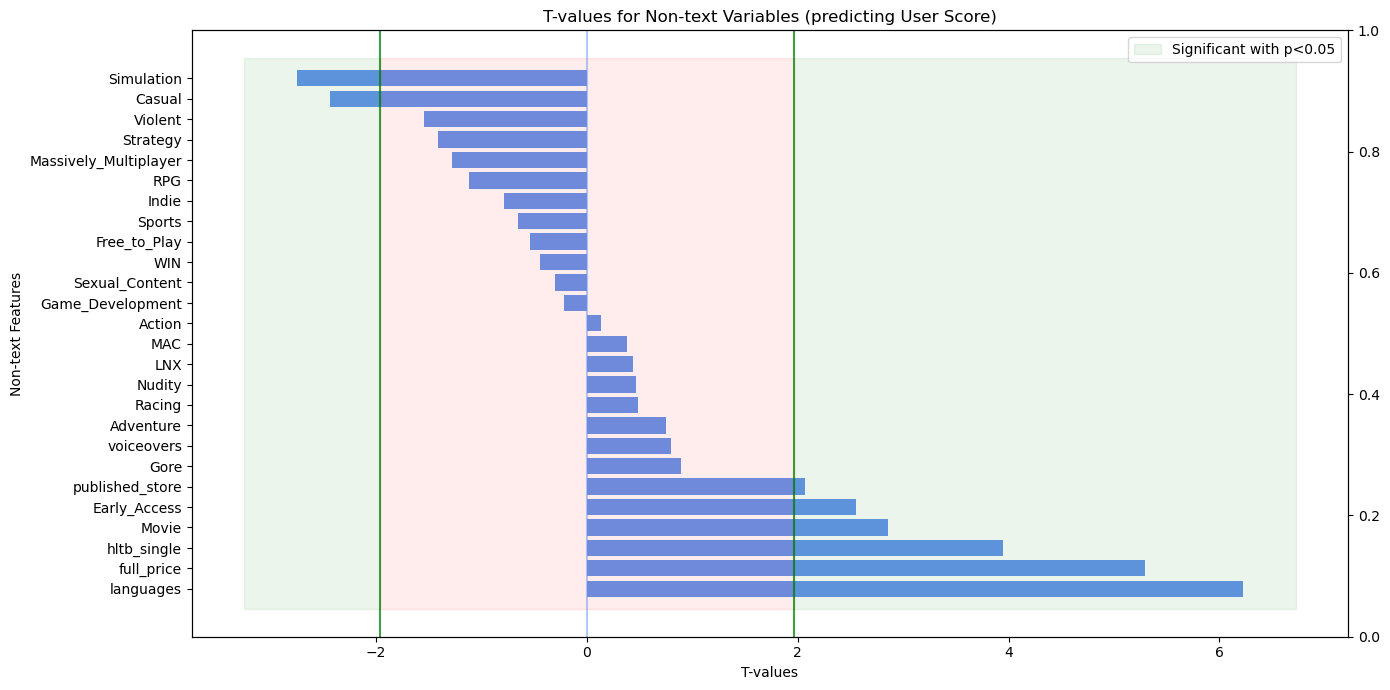

In [8]:

## Analyses including hltb_single as feature
        
NLP_owners_with_hltb_single = NLPAnalyzer(df.drop(["name", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", "store_uscore", 
                                  "igdb_popularity"], axis=1), 
                         "stsp_owners", "Owners",
                         [0, 25, 50, 100, 150, 200, 250],
                        naming_suffix="_with_hltb_single")
results_owners_with_hltb_single = NLP_owners_with_hltb_single.analyze()

NLP_uscore_with_hltb_single = NLPAnalyzer(df.drop(["name", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description",
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "store_uscore", "User Score",
                         [0, 25, 50, 100, 150, 200, 250],
                        naming_suffix="_with_hltb_single")
results_uscore_with_hltb_single = NLP_uscore_with_hltb_single.analyze()

## Step 5: Printing and plotting most influential words

************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************
************************************************** 
 Using BOW Vectorizer 
 **************************************************


C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************
Word: adventure, t-values: -3.540428076832775
Word: control, t-values: -2.668444845853679
Word: different, t-values: -2.4827218331878425
Word: experience, t-values: 3.1729198124607834
Word: li, t-values: -2.061773764072601
Word: life, t-values: 3.0427077662280926
Word: new, t-values: 5.532963154418609
Word: player, t-values: 2.210768822718004
Word: puzzle, t-values: -1.9892732552405121
Word: strong, t-values: 2.065600880317643
Word: world, t-values: 2.669462473001845
Word: adventure, t-values: 4.317623308281385
Word: battle, t-values: 2.215492890146046
Word: build, t-values: -3.387489401782405
Word: challenge, t-values: 4.607604365540284
Word: character, t-values: 4.64403936143562
Word: choose, t-values: -2.731605564149682
Word: different, t-values: -4.504168654503734
Word: features, t-values: -6.876405626089431
Word: fight, t-values: -2.417219195

C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


([('new', 5.532963154418609),
  ('experience', 3.1729198124607834),
  ('life', 3.0427077662280926),
  ('world', 2.669462473001845),
  ('player', 2.210768822718004),
  ('strong', 2.065600880317643),
  ('puzzle', -1.9892732552405121),
  ('li', -2.061773764072601),
  ('different', -2.4827218331878425),
  ('control', -2.668444845853679),
  ('adventure', -3.540428076832775)],
 [('li', 9.160508279148344),
  ('friend', 6.287970745620616),
  ('unique', 6.137717559641116),
  ('strong', 5.3766178783511585),
  ('puzzle', 5.044066654877594),
  ('character', 4.64403936143562),
  ('challenge', 4.607604365540284),
  ('adventure', 4.317623308281385),
  ('quot', 3.8495691549425968),
  ('story', 3.79242771220875),
  ('new', 3.3683058012676788),
  ('power', 2.910856546158728),
  ('level', 2.9102968502020308),
  ('gameplay', 2.8476829634601106),
  ('make', 2.801798443859806),
  ('way', 2.631086494111608),
  ('support', 2.4858196289381467),
  ('battle', 2.215492890146046),
  ('play', 2.0072985142658784),
 

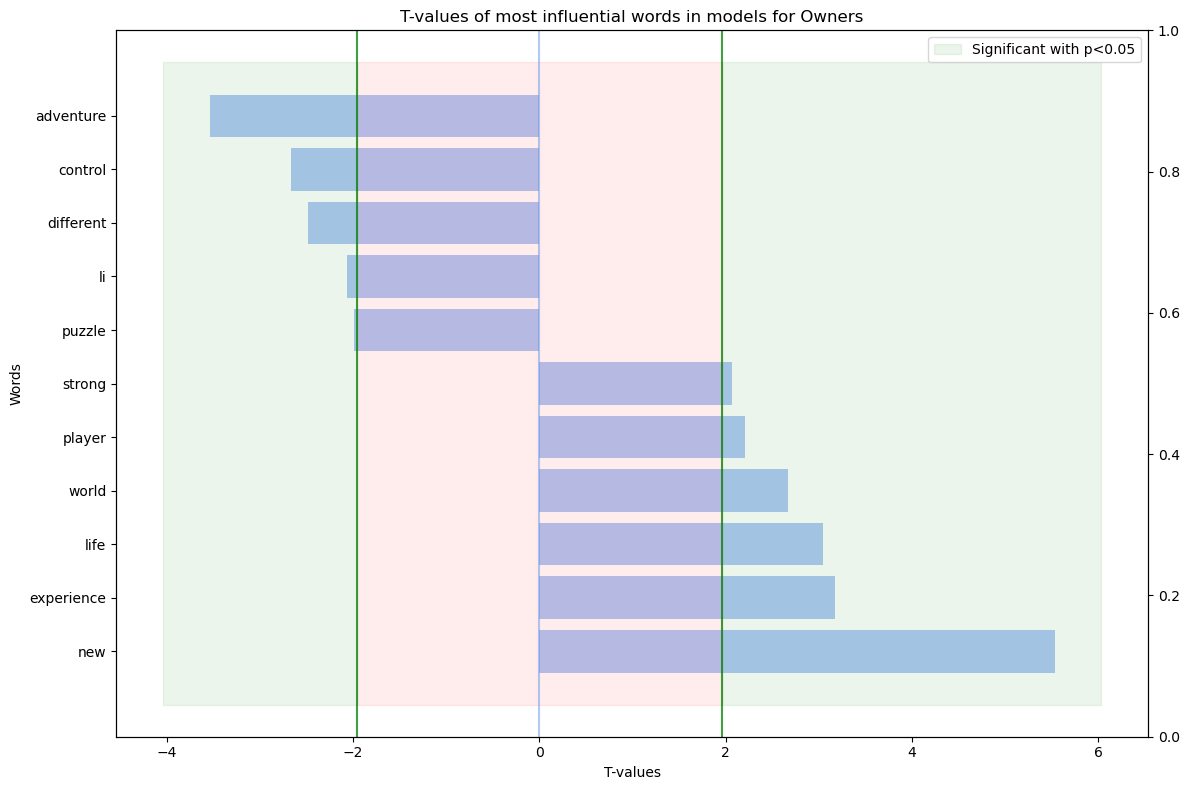

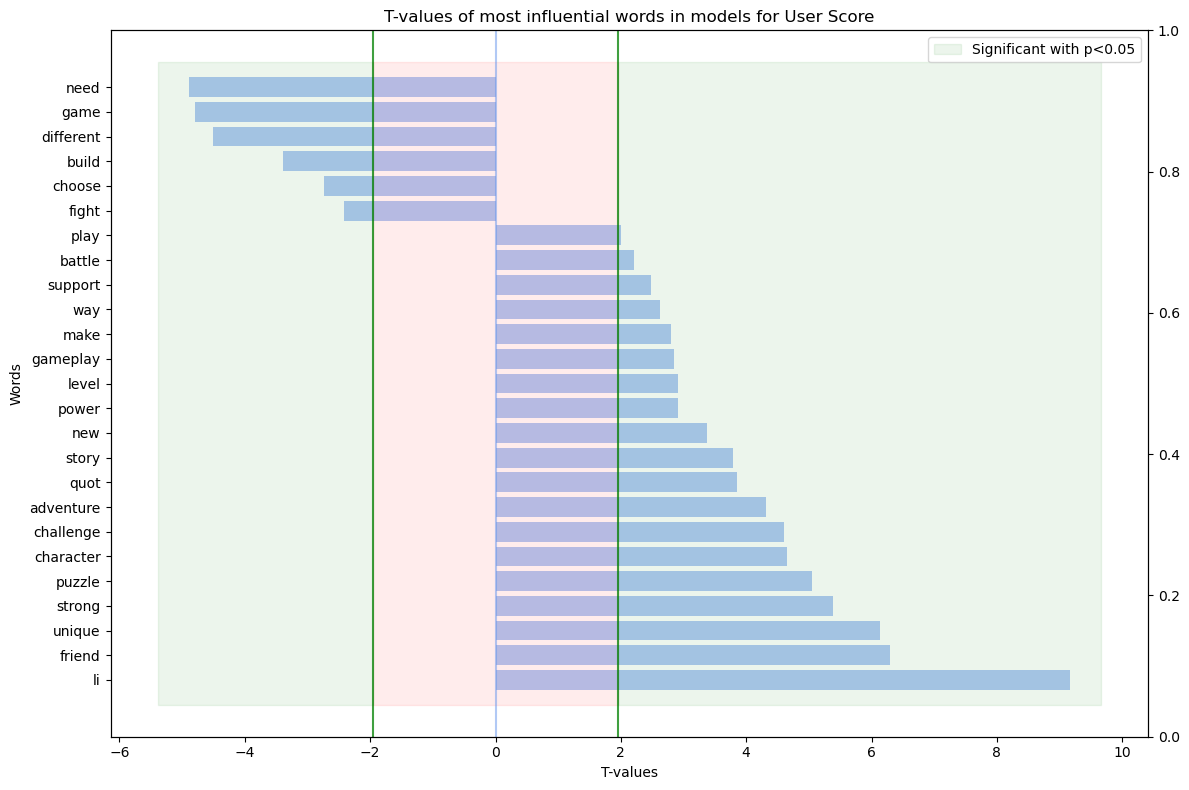

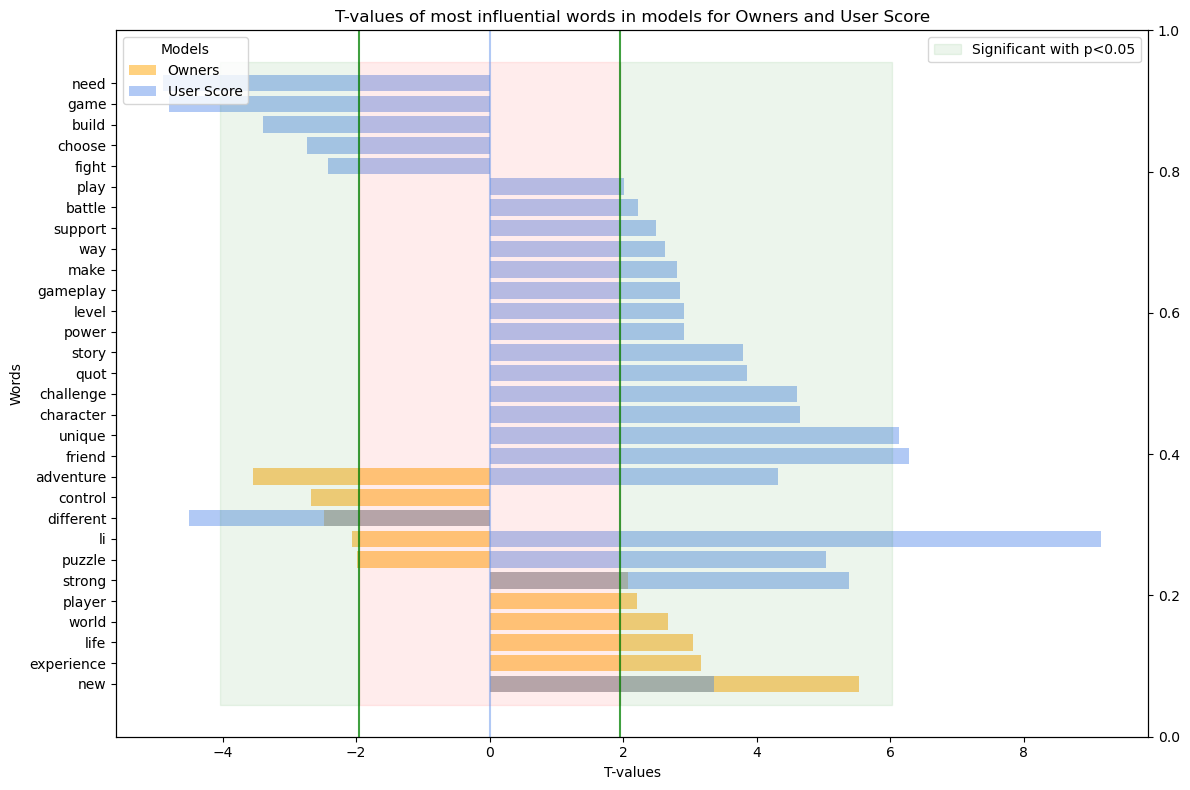

In [9]:

## Extract words using NLPAnalyzer:
words_owners = NLP_owners.extract_words(50)
words_uscore= NLP_uscore.extract_words(50)
        
# Printing significant words and corresponding t-values
for word_list in [words_owners, words_uscore]:
    for word, tv1 in word_list:
        print(f"Word: {word}, t-values: {tv1}")

## Plotting most influential words using NLPAnalyzer:
## Single plot for prediction of owners
NLP_owners.plot_words()
## Single plot for prediction of owners
NLP_uscore.plot_words()
## Combined plot for prediction of owners and user score
NLP_owners.plot_words_multi(words_owners, words_uscore, "Owners", "User Score")    

************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************
************************************************** 
 Using BOW Vectorizer 
 **************************************************


C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************
Word: adventure, t-values: -3.1783205110595705
Word: battle, t-values: -3.4092893980263934
Word: different, t-values: -2.9199514102414366
Word: include, t-values: 5.433847510145811
Word: li, t-values: -1.9778623604185717
Word: life, t-values: 3.4609066089013685
Word: new, t-values: 3.7631118466022713
Word: player, t-values: 4.498939463220283
Word: puzzle, t-values: -3.37138730364118
Word: quot, t-values: -2.8475218823495143
Word: way, t-values: 2.3323336049447962
Word: weapon, t-values: 2.0780786149268082
Word: world, t-values: 3.7208942484941505
Word: base, t-values: -2.118028652697381
Word: character, t-values: 3.016490073641839
Word: different, t-values: -5.5381782046403245
Word: features, t-values: -2.0235525431265624
Word: fight, t-values: -2.066696438381061
Word: friend, t-values: 3.254520378967063
Word: key, t-values: -2.2505212813622997
Wo

C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\AppData\Local\Temp\ipykernel_13636\4154691187.py:508: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


([('include', 5.433847510145811),
  ('player', 4.498939463220283),
  ('new', 3.7631118466022713),
  ('world', 3.7208942484941505),
  ('life', 3.4609066089013685),
  ('way', 2.3323336049447962),
  ('weapon', 2.0780786149268082),
  ('li', -1.9778623604185717),
  ('quot', -2.8475218823495143),
  ('different', -2.9199514102414366),
  ('adventure', -3.1783205110595705),
  ('puzzle', -3.37138730364118),
  ('battle', -3.4092893980263934)],
 [('li', 6.751555928244927),
  ('friend', 3.254520378967063),
  ('character', 3.016490073641839),
  ('new', 2.9205896390648918),
  ('strong', 2.630510539525327),
  ('puzzle', 2.4553533118521726),
  ('unique', 2.3146247134401463),
  ('make', 2.2088348342590036),
  ('quot', 2.0025311815366953),
  ('features', -2.0235525431265624),
  ('fight', -2.066696438381061),
  ('base', -2.118028652697381),
  ('key', -2.2505212813622997),
  ('player', -3.8669259338117263),
  ('different', -5.5381782046403245)])

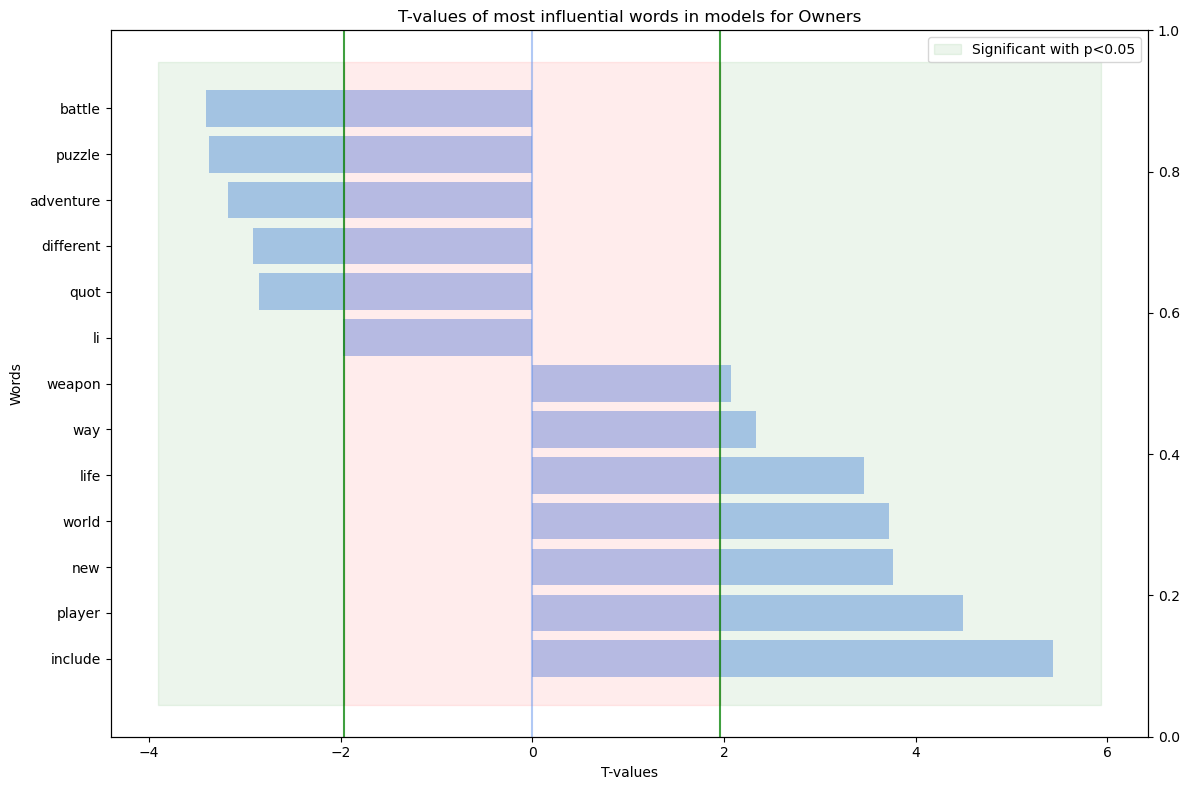

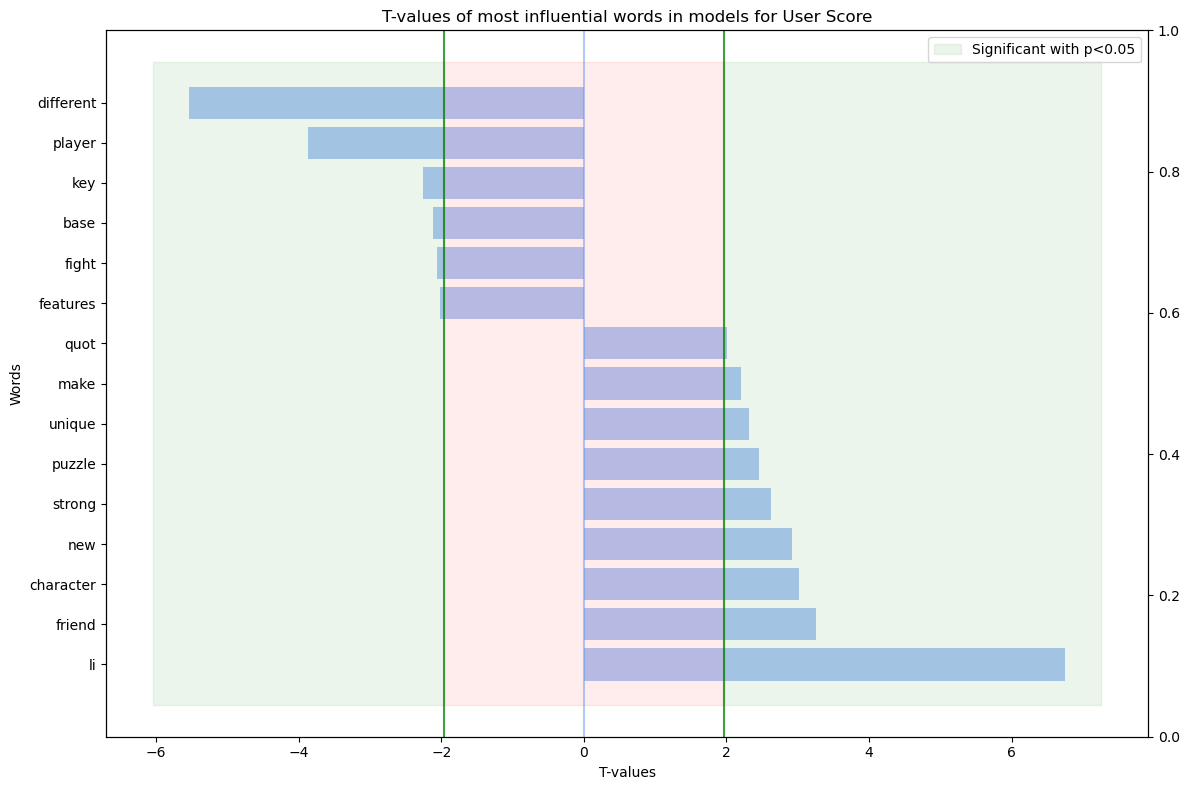

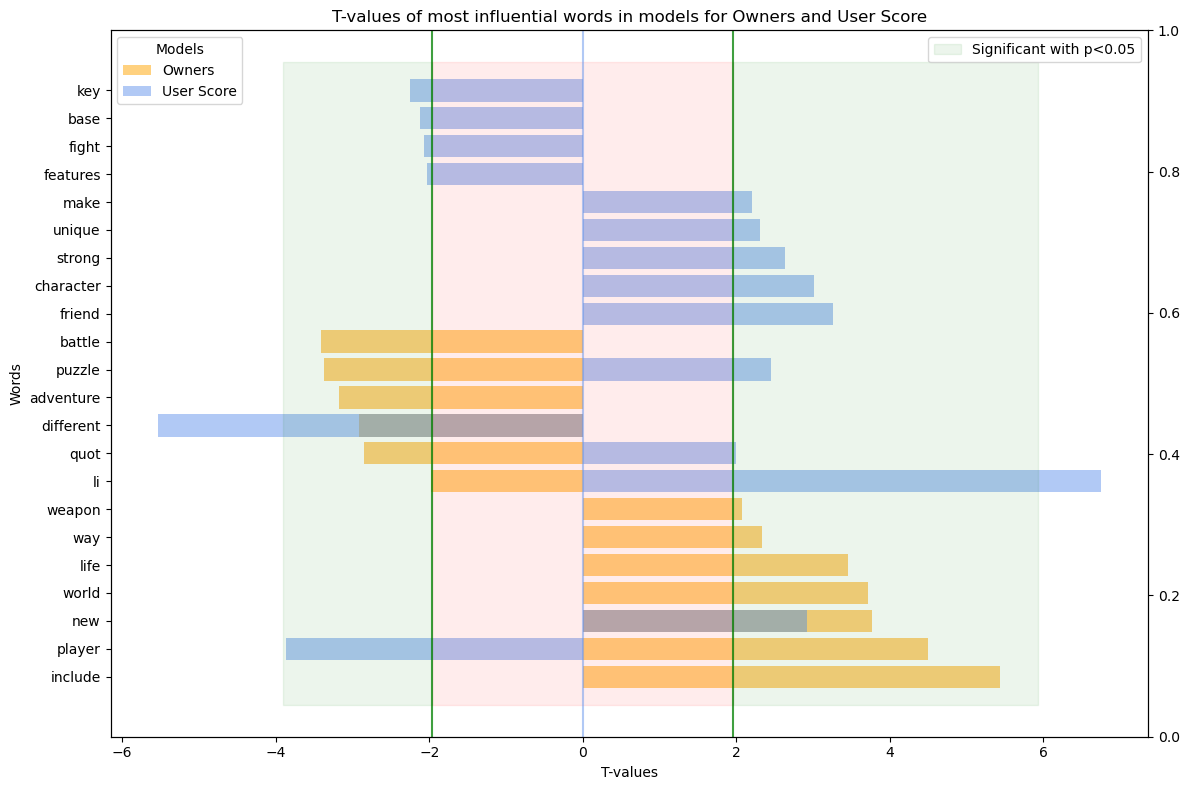

In [10]:

## Extract words using NLPAnalyzer - for analyses including hltb_single as feature:
words_owners_with_hltb_single = NLP_owners_with_hltb_single.extract_words(50)
words_uscore_with_hltb_single= NLP_uscore_with_hltb_single.extract_words(50)
        
# Printing significant words and corresponding t-values
for word_list in [words_owners_with_hltb_single, words_uscore_with_hltb_single]:
    for word, tv1 in word_list:
        print(f"Word: {word}, t-values: {tv1}")

## Plotting most influential words using NLPAnalyzer:
## Single plot for prediction of owners
NLP_owners_with_hltb_single.plot_words()
## Single plot for prediction of owners
NLP_uscore_with_hltb_single.plot_words()
## Combined plot for prediction of owners and user score
NLP_owners_with_hltb_single.plot_words_multi(words_owners_with_hltb_single, words_uscore_with_hltb_single, "Owners", "User Score")    